# Problem 14: Head-Dependent Boundary Conditions

## INTRODUCTION
_The_ [RIVER](https://github.com/jordw22/modflow_epa/blob/master/terms%20and%20definitions.md#r), [DRAIN](https://github.com/jordw22/modflow_epa/blob/master/terms%20and%20definitions.md#d), [GENERAL HEAD](https://github.com/jordw22/modflow_epa/blob/master/terms%20and%20definitions.md#g), _and_ [EVAPOTRANSPIRATION](https://github.com/jordw22/modflow_epa/blob/master/terms%20and%20definitions.md#e) _packages of_ [MODFLOW](https://github.com/jordw22/modflow_epa/blob/master/terms%20and%20definitions.md#m) _are all head-dependent flux or third type boundary conditions. Although their names imply specific types of sources or_ [sinks](https://github.com/jordw22/modflow_epa/blob/master/terms%20and%20definitions.md#s), _these packages are mathematically very similar and can be used for a variety of hydrologic conditions other than those their names suggest. This exercise illustrates the similarity of the packages, compares results of each to one another as a verification, and gives insight to the utility of parameters used in the packages._


## PROBLEM STATEMENT AND DATA
_In order to evaluate these boundary conditions, a single layer, 7 node by 7 node_ [unconfined aquifer](https://github.com/jordw22/modflow_epa/blob/master/terms%20and%20definitions.md#u) _is modeled in parts a-d. All cells in the domain are active and a well pumps in the upper left-hand corner (node 1,1). A head-dependent flux boundary condition runs along column 4 for the entire length of the system. The boundary will be treated in five different ways in this exercise. Details on the model specific to all configurations are given in Table 14.1._


### Part a) 
_Model the third type boundary condition as a river running down the center of column 4. The river has the following characteristics:_
    
| Variable                        | Value    |
|---------------------------------|----------|
| Elevation                       | 0.0 ft   |
| Width                           | 20 ft    |
| Riverbed hydraulic conductivity | 0.1 $\frac{ft}{d}$ |
| Riverbed thickness              | 1 ft     |
| River bottom elevation          | -2.0 ft  |

_Run the model for the 1 year simulation period described in Table 14.1. Note hydraulic head and boundary discharge at row 1, column 4 for each time step. You will need to invoke the cell-by-cell print flag in both the river package and the [output control package](https://github.com/jordw22/modflow_epa/blob/master/terms%20and%20definitions.md#o)._

###  Table 14.1. Aquifer parameters and discretization data for Problem 14
| Variable                     | Value       |
|------------------------------|-------------|
| Initial head                 | 10 ft       |
| Hydraulic conductivity       | 10 $\frac{ft}{d}$     |
| Aquifer base                 | -50 ft      |
| Storage coefficient          | 0.1         |
| Grid spacing (uniform)       | 100 ft      |
| Pumping rate                 | 2500 $\frac{ft^2}{d}$ |
| Stress period length         | 365 days    |
| Time steps                   | 20          |
| Time step multiplier         | 1.2         |
| SIP iteration parameters     | 5           |
| Maximum number of iterations | 50          |
| Acceleration parameter       | 1           |
| Closure criterion            | 0.001       |

In [3]:
#Import and modules/packages that we need to work with
%matplotlib inline
import os
import sys
import platform
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import flopy

In [4]:
print(os.getcwd())
delr = [] #creates an empty list
f = open('../Data/table14.1.csv') #opens the csv file; the two periods (.) means that you are goin backwards into the folders.
    
    #the four loop below creates a statement that if i == 0 (if it's the first
    #row then it will skip it (continue) and move on with the for loop)
    #we skip the first row in our table/csv file because the headers would give
    #us an error since they aren't numerical values.
for i,line in enumerate(f):
    if i == 0: 
        continue
        
    #"line.strip" gets rid of any extra spaces in the margins of the plot
    #"split" sections of the individual values according to whatever you put in the quotes
    linelist = line.strip().split(',') 
    
    value = float(linelist[1]) #changes the values in the list to floats
    print(value) #prints the values
    delr.append(value) #puts the floats into the empty list, delr 
    
print(delr) #prints the list

C:\VT\USGS Internship\modflow_epa.git\Notebooks
10.0
10.0
-50.0
0.1
100.0
2500.0
365.0
20.0
1.2
5.0
50.0
1.0
0.001
[10.0, 10.0, -50.0, 0.1, 100.0, 2500.0, 365.0, 20.0, 1.2, 5.0, 50.0, 1.0, 0.001]


In [5]:
#Store the values of each parameter into separate variables
inh = 10.0 #initial head
hk = 10.0 #hydraulic conductivity
botm = -50.0 #aquifer base
sy = 0.1 #storage coefficient
delr = 100 #grid spacing (uniform)
delc = delr
pr = -2500. #pumping rate
perlen = 365 #final time (stress period length)
nstp = 20 #number of time steps
tsmult = 1.2 #time step multiplier
sip_it_par = 5 #SIP iteration parameters
mxiter = 50 #maximum number of iterations
accel_par = 1.0 #acceleration parameter
hclose = 0.001 #closure criterion (the head change criterion for convergence)
nlay = 1 #number of layers
nrow = 7 #number of rows
ncol = 7 #number of columns

#Flopy objects
modelname = 'p14_pa' #short for problem 14 part a
exe_name = '../MF2005.1_12/bin/mf2005.exe'
model_ws = 'temp'
mf = flopy.modflow.Modflow(modelname, exe_name=exe_name, model_ws = model_ws)

#call in the discretization package
top = 10 #an array of the top elevation of layer 1
nper = 1 #number of periods
dis = flopy.modflow.ModflowDis(mf, nlay, nrow, ncol, delr=delr, delc=delc,
                               top=top, botm=botm, nper=nper, perlen=perlen, 
                               nstp=nstp, tsmult=tsmult, steady=False)

#call in the basic package
ibound = np.ones((nlay, nrow, ncol))
strt = 10
bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)

#call in the layer-propery flow (LPF)
laytyp = 1
ipakcb = 50
lpf = flopy.modflow.ModflowLpf(mf, hk=hk, sy=sy, laytyp=laytyp, ipakcb=ipakcb)

#call in the well package (WEL)
# Remember to use zero-based layer, row, column indices!
wel_sp1 = [[0, 0, 0, pr]]
wel_spd = {0: wel_sp1}
wel = flopy.modflow.ModflowWel(mf, stress_period_data=wel_spd)


#call in the preconditioned conjugate-gradient package (PCG) 
pcg = flopy.modflow.ModflowPcg(mf, mxiter=mxiter, hclose=hclose)

#call in the output control package (OC)
oc = flopy.modflow.ModflowOc(mf, stress_period_data={(0, 0): ['save head', 'print budget', 'save budget']})

#call in the river package (RIV)
ipakcb = 50
riv_stage = 0.0
#conductance is equal to hydraulic conductance, times the width of the river, times the length of the river,
#all divided by the riverbed thickness
riv_cond = (.1 * 20 * 100) / 1
rbot = -2.0

#this is how we were writing it on multiple lines
#riv_sp1 = [[0, 0, 3, riv_stage, riv_cond, rbot], 
#           [0, 1, 3, riv_stage, riv_cond, rbot], 
#           [0, 2, 3, riv_stage, riv_cond, rbot],
#           [0, 3, 3, riv_stage, riv_cond, rbot], 
#           [0, 4, 3, riv_stage, riv_cond, rbot], 
#           [0, 5, 3, riv_stage, riv_cond, rbot], 
#           [0, 6, 3, riv_stage, riv_cond, rbot]]

#or you can write it like this in just one line
riv_sp1 = [[0, row, 3, riv_stage, riv_cond, rbot] for row in range(nrow) ]

riv_spd = {0: riv_sp1}
riv = flopy.modflow.ModflowRiv(mf, ipakcb=ipakcb, stress_period_data=riv_spd)


[[0, row, 3, riv_stage, riv_cond, rbot] for row in range(nrow) ]

# Write the MODFLOW model input files
mf.write_input()

# Run the MODFLOW model
success, buff = mf.run_model()

FloPy is using the following executable to run the model: ../MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: p14_pa.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2017/08/18 15:00:10

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     8    Gro

In [6]:
import flopy.utils.binaryfile as bf

# Create the headfile object
fname = os.path.join(model_ws, 'p14_pa.hds') #"os.path.join" joins together the modelname and the .hds file and stores it in fname
headobj = bf.HeadFile(fname) #create headobj and put values from fname (aka 'p1_pa.hds') inside it

#print hydraulic head (Table 14.2)
ts = headobj.get_ts([[0, 0, 3]])
print(ts)

[[  1.95513248e+00   8.51035500e+00]
 [  4.30129147e+00   7.53955841e+00]
 [  7.11668205e+00   6.71613359e+00]
 [  1.04951515e+01   5.92555618e+00]
 [  1.45493145e+01   5.12856054e+00]
 [  1.94143105e+01   4.31294441e+00]
 [  2.52523060e+01   3.48044372e+00]
 [  3.22579002e+01   2.64200115e+00]
 [  4.06646156e+01   1.81514466e+00]
 [  5.07526741e+01   1.02176082e+00]
 [  6.28583450e+01   2.85528183e-01]
 [  7.73851471e+01  -3.71194184e-01]
 [  9.48173141e+01  -9.30725336e-01]
 [  1.15735916e+02  -1.38299954e+00]
 [  1.40838242e+02  -1.72731316e+00]
 [  1.70961029e+02  -1.97227108e+00]
 [  2.07108383e+02  -2.17559099e+00]
 [  2.50485199e+02  -2.33867145e+00]
 [  3.02537384e+02  -2.44961953e+00]
 [  3.65000000e+02  -2.52252889e+00]]


In [7]:
import pandas as pd
table2a = pd.read_csv('../Data/table14.2.csv')

table2a.columns #displays all the column names in the file
#drops the columns that you enter into the list
table2a.drop(['GHB (part b)', 'Drain (part c)', 'E-T (part d)', 'Constant head (part e)'], 
             axis=1, inplace=True)
#prints out the first 5 rows into a table
table2a.head()

,Time Step,Ellapsed Time (days),River (part a)
0,1,1.955,8.510
1,2,4.301,7.540
2,3,70117.000,6.716
3,4,10.495,5.926
4,5,14.549,5.129


In [8]:
#prints the whole dataframe instead of just the first 5 rows
print(table2a)

    Time Step  Ellapsed Time (days)  River (part a)
0           1                 1.955           8.510
1           2                 4.301           7.540
2           3             70117.000           6.716
3           4                10.495           5.926
4           5                14.549           5.129
5           6                19.414           4.313
6           7                25.252           3.481
7           8                32.258           2.643
8           9                40.655           1.816
9          10                50.753           1.023
10         11                62.858           0.286
11         12                77.385          -0.371
12         13                94.817          -0.930
13         14               115.740          -1.382
14         15               140.840          -1.727
15         16               170.960          -1.972
16         17               207.110          -2.175
17         18               250.490          -2.337
18         1

### Table 14.2. Hydraulic head at node (1,4) for part a representing the third type boundary condition

Check your results to make sure they match with the table from the book

| Time Step | Elapsed Time (days) | River (part a) |
|-----------|---------------------|----------------|
| 1         | 1.955               | 8.51           |
| 2         | 4.301               | 7.54           |
| 3         | 7.117               | 6.716          |
| 4         | 10.495              | 5.926          |
| 5         | 14.549              | 5.129          |
| 6         | 19.414              | 4.313          |
| 7         | 25.252              | 3.481          |
| 8         | 32.258              | 2.643          |
| 9         | 40.655              | 1.816          |
| 10        | 50.753              | 1.023          |
| 11        | 62.858              | 0.286          |
| 12        | 77.385              | -0.371         |
| 13        | 94.817              | -0.93          |
| 14        | 115.74              | -1.382         |
| 15        | 140.84              | -1.727         |
| 16        | 170.96              | -1.972         |
| 17        | 207.11              | -2.175         |
| 18        | 250.49              | -2.337         |
| 19        | 302.54              | -2.448         |
| 20        | 365                 | -2.52          |

In [9]:
#print discharge values (Table 14.3)
fname = os.path.join(model_ws, 'p14_pa.cbc')
cbb = flopy.utils.CellBudgetFile(fname)
frf = cbb.get_data(text='FLOW RIGHT FACE')[19]
fff = cbb.get_data(text='FLOW FRONT FACE')[19]

riv_flow = cbb.get_data(text='RIVER LEAKAGE') #create an array/for loop to get out first value of every step
#cbb.list_records()

#create new list
riv_list=[]
#dtype tells you what data type riv_flow is
print (riv_flow[0].dtype)
#create for loop to store only the first value of each time step from riv_flow into riv_list
for riv in riv_flow:
    riv_list.append(riv['q'][0])
    
print(riv_list)

(numpy.record, [('node', '<i4'), ('q', '<f4')])
[-1702.071, -1507.9116, -1343.2268, -1185.1113, -1025.712, -862.58887, -696.08875, -528.40021, -363.02893, -204.35217, -57.105637, 74.238838, 186.14507, 276.59991, 345.46265, 394.45422, 400.0, 400.0, 400.0, 400.0]


In [10]:
import pandas as pd
table3a = pd.read_csv('../Data/table14.3.csv')

table3a.columns #displays all the column names in the file
#drops the columns that you enter into the list
table3a.drop(['GHB (part b)', 'Drain (part c)',
       'E-T (part d)', 'Constant head (part e)'], axis=1, inplace=True)
#prints out the first 5 rows into a table
table3a.head()

,Time Step,Elapsed Time (days),River (part a)
0,1,1.955,-1702.071
1,2,4.301,-1507.910
2,3,7.117,-1343.224
3,4,10.495,-1185.109
4,5,14.549,-1025.712


In [11]:
#prints the whole dataframe instead of just the first 5 rows
print(table3a)

    Time Step  Elapsed Time (days)  River (part a)
0           1                1.955       -1702.071
1           2                4.301       -1507.910
2           3                7.117       -1343.224
3           4               10.495       -1185.109
4           5               14.549       -1025.712
5           6               19.414        -862.600
6           7               25.252        -696.128
7           8               32.258        -528.506
8           9               40.655        -363.187
9          10               50.753        -204.534
10         11               62.858         -57.278
11         12               77.385          74.103
12         13               94.817         186.031
13         14              115.740         276.494
14         15              140.840         345.353
15         16              170.960         394.344
16         17              207.110         400.000
17         18              250.490         400.000
18         19              302.

### Table 14.3. Discharge for part a representing the third type boundary condition

Check your results to make sure they match with the table from the book

| Time Step | Elapsed Time (days) | River (part a) |
|-----------|---------------------|----------------|
| 1         | 1.955               | -1702.071      |
| 2         | 4.301               | -1507.91       |
| 3         | 7.117               | -1343.224      |
| 4         | 10.495              | -1185.109      |
| 5         | 14.549              | -1025.712      |
| 6         | 19.414              | -862.6         |
| 7         | 25.252              | -696.128       |
| 8         | 32.258              | -528.506       |
| 9         | 40.655              | -363.187       |
| 10        | 50.753              | -204.534       |
| 11        | 62.858              | -57.278        |
| 12        | 77.385              | 74.103         |
| 13        | 94.817              | 186.031        |
| 14        | 115.74              | 276.494        |
| 15        | 140.84              | 345.353        |
| 16        | 170.96              | 394.344        |
| 17        | 207.11              | 400            |
| 18        | 250.49              | 400            |
| 19        | 302.54              | 400            |
| 20        | 365                 | 400            |

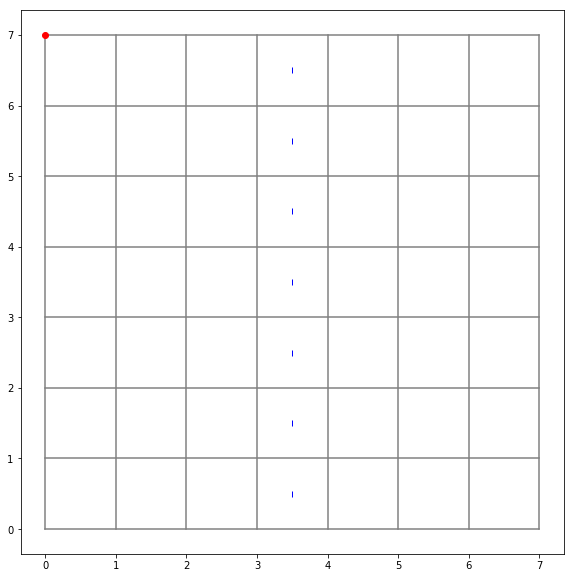

In [12]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
ymax = 7
ymin = 0
xmax = ymax #makes xmax equal to ymax which is equal to the sum of the list
xmin = 0
x = 0
y = 0

plt.plot([xmin, xmin], [ymin, ymax], 'gray') #plots the first column line. Must be outside of the loop

for dx in range(0,7): #dx will go through the values in delr one by one in the loop
    x = x + 1 #add the dx value to x, which is zero, and then store that new value into x
    plt.plot([x, x], [ymax, ymin], 'gray') #plot that point and then loop back to top

    #repeat the process above but with the y values to make the rows
plt.plot([xmin, xmax], [ymin, ymin], 'gray') #plots the first row line. Must be outside of the loop

for dy in range(0,7): 
    y = y + 1
    plt.plot([xmin, xmax], [y, y], 'gray')

#create well in top left corner (1, 1)
def plot_well(xmin, ymax, sym):
    plt.plot(xmin, ymax, sym)
plot_well(xmin, ymax, sym='ro')

#create river down mid of col 4
def plot_riv1(xmin, ymax, sym):
    plt.plot(xmin, ymax, sym)
plot_well(xmin + 3.5, ymax - .5, sym='b|')

def plot_riv1(xmin, ymax, sym):
    plt.plot(xmin, ymax, sym)
plot_well(xmin + 3.5, ymax - 1.5, sym='b|')

def plot_riv1(xmin, ymax, sym):
    plt.plot(xmin, ymax, sym)
plot_well(xmin + 3.5, ymax - 2.5, sym='b|')

def plot_riv1(xmin, ymax, sym):
    plt.plot(xmin, ymax, sym)
plot_well(xmin + 3.5, ymax - 3.5, sym='b|')

def plot_riv1(xmin, ymax, sym):
    plt.plot(xmin, ymax, sym)
plot_well(xmin + 3.5, ymax - 4.5, sym='b|')

def plot_riv1(xmin, ymax, sym):
    plt.plot(xmin, ymax, sym)
plot_well(xmin + 3.5, ymax - 5.5, sym='b|')

def plot_riv1(xmin, ymax, sym):
    plt.plot(xmin, ymax, sym)
plot_well(xmin + 3.5, ymax - 6.5, sym='b|')

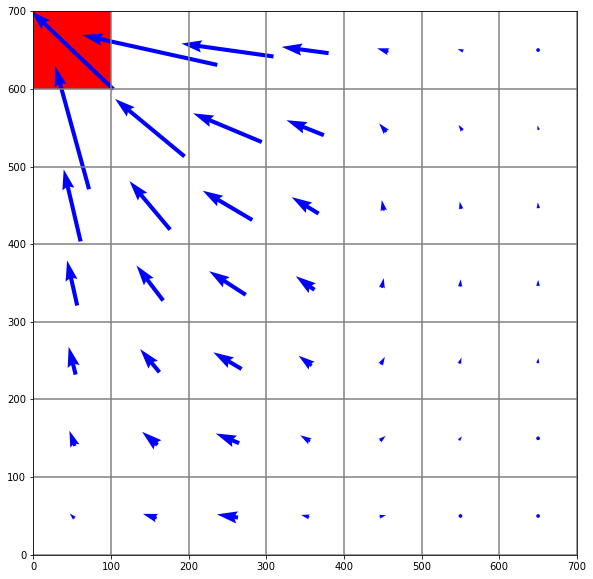

In [13]:
#plot arrows (quivers) that point in the direction of water flowb
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

modelmap = flopy.plot.ModelMap(model=mf)
modelmap.plot_bc("WEL")
quadmesh = modelmap.plot_ibound()
quiver = modelmap.plot_discharge(frf, fff, color='b')
linecollection = modelmap.plot_grid()

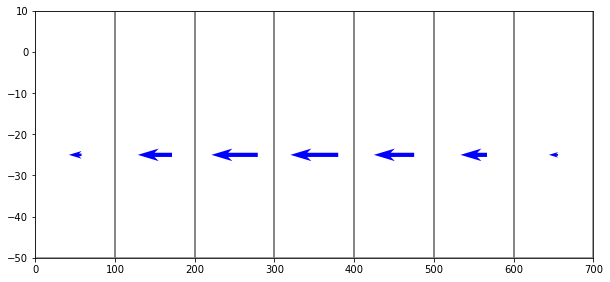

In [14]:
#show plot_array() and plot_discharge()
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(2, 1, 1)
modelxsect = flopy.plot.ModelCrossSection(model=mf, ax=ax, line={'Column':6})
linecollection = modelxsect.plot_grid()
quiver = modelxsect.plot_discharge(frf, fff, hstep=1, normalize=False, color='b', headwidth=3, headaxislength=4) 
patches = modelxsect.plot_ibound()

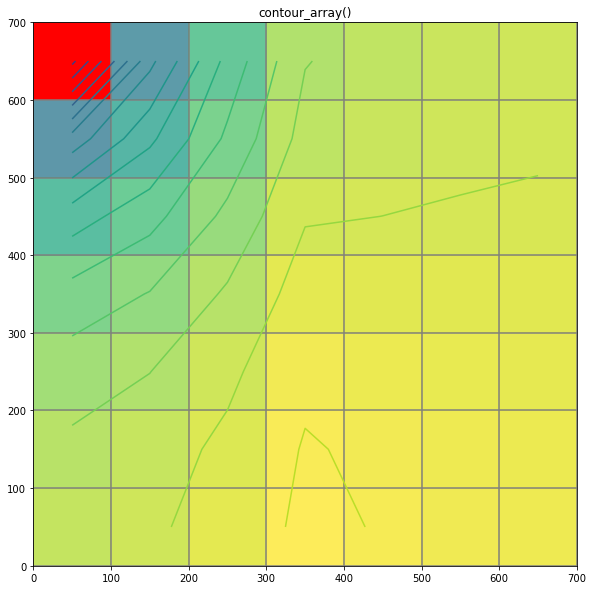

In [15]:
fname = os.path.join(model_ws, 'p14_pa.cbc')
head = headobj.get_data()
levels = np.arange(-10, 0, .5)

fig = plt.figure(figsize=(10, 10))

#plot_array
ax = fig.add_subplot(1, 1, 1, aspect='equal')
ax.set_title('contour_array()')
modelmap = flopy.plot.ModelMap(model=mf)
quadmesh = modelmap.plot_ibound()
quadmesh = modelmap.plot_array(head, masked_values=[999.], alpha=0.5)
modelmap.plot_bc("WEL")
linecollection = modelmap.plot_grid()
contour_set = modelmap.contour_array(head, masked_values=[999.], levels=levels)


<a list of 10 text.Text objects>

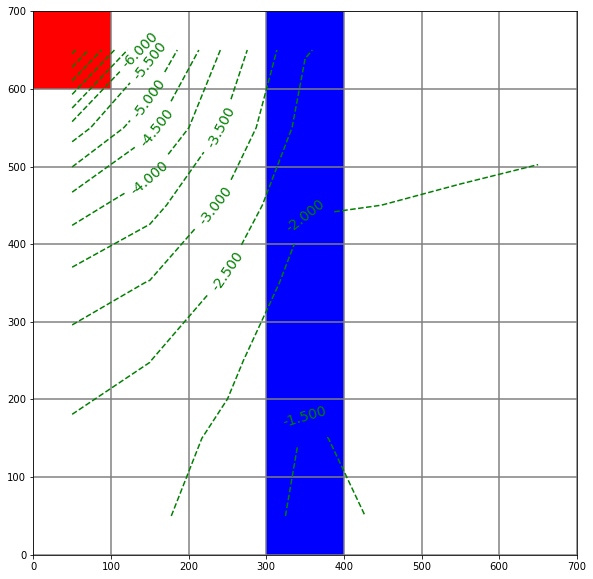

In [16]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
modelmap = flopy.plot.ModelMap(model=mf)
quadmesh = modelmap.plot_ibound()
linecollection = modelmap.plot_grid()
riv = modelmap.plot_bc('RIV', color='b', plotAll=True)
quadmesh = modelmap.plot_bc('WEL', kper=1, plotAll=True)
contour_set = modelmap.contour_array(head, levels=np.arange(-10, 0, 0.5), colors='g')
plt.clabel(contour_set, inline=1, fontsize=14)

(0, 365.0)

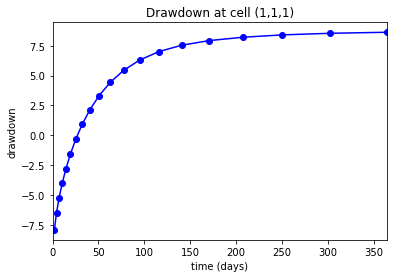

In [17]:
# Plot the drawdown versus time
idx = (0, 0, 0) #(nlay, nrow, ncol) *remember you have to subtract 1 from the original numbers for python - (1, 10, 12)*
ts = headobj.get_ts(idx)
plt.subplot(1, 1, 1)
ttl = 'Drawdown at cell ({0},{1},{2})'.format(idx[0] + 1, idx[1] + 1, idx[2] + 1) #we are adding 1 to each part of idx to that it prints out the real values and not the code values
plt.title(ttl) #prints/plots title
plt.xlabel('time (days)') #labels the x-axis
plt.ylabel('drawdown') #labels the y-axis
#here we do "0-ts..." in order to show the drawdown of 
plt.plot(ts[:, 0], 0-ts[:, 1], 'bo-') #(x, y, color/type of line)
plt.xlim(0, ts[:, 0].max())

(0, 365.0)

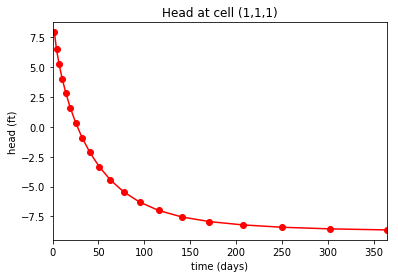

In [16]:
# Plot the head versus time
idx = (0, 0, 0)
ts = headobj.get_ts(idx)
plt.subplot(1, 1, 1)
ttl = 'Head at cell ({0},{1},{2})'.format(idx[0] + 1, idx[1] + 1, idx[2] + 1)
plt.title(ttl)
plt.xlabel('time (days)')
plt.ylabel('head (ft)')
plt.plot(ts[:, 0], ts[:, 1], 'ro-')
plt.xlim(0, ts[:, 0].max())